In [23]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc
import nibabel as nib
from scipy import special
import ipywidgets as widgets

# Loading the ensemble

In [10]:
ds_2 = nc.Dataset('../../Data/DEMETER/original format/day20_2meter_temp_C.nc')
ds_200 = nc.Dataset('../../Data/DEMETER/original format/day20_200_temp.nc')
ds_500 = nc.Dataset('../../Data/DEMETER/original format/day20_500_temp.nc')
ds_850 = nc.Dataset('../../Data/DEMETER/original format/day20_850_temp.nc')
heights = [ds_2, ds_200, ds_500, ds_850]
print(ds_2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2009-05-19 17:02:00 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), number(9), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 number(number), int32 time(time), int16 cnrm(time, number, latitude, longitude), int16 crfc(time, number, latitude, longitude), int16 lody(time, number, latitude, longitude), int16 scnr(time, number, latitude, longitude), int16 scwf(time, number, latitude, longitude), int16 smpi(time, number, latitude, longitude), int16 ukmo(time, number, latitude, longitude)
    groups: 


# Joining the ensemble heights

In [15]:
simulations = ['cnrm', 'lody']

models = np.empty(( len(simulations), ds_2.dimensions['longitude'].size, ds_2.dimensions['latitude'].size, 4, 9))
for height,ds in enumerate(heights):
    for idx,sim in enumerate(simulations):
        ensemble = ds[sim][0]
        models[idx,:,:,height,:] = ensemble.T

print(models.shape)

(2, 144, 73, 4, 9)


# Calculate the absolute difference

In [16]:
difference_ensemble = np.empty( (ds_2.dimensions['longitude'].size, ds_2.dimensions['latitude'].size, 4, 9) )
for sample in range(9):
    difference_ensemble[:, :, :, sample] = np.abs(models[0,:, :, :, sample] - models[1, :, :, :, sample])

print(difference_ensemble.shape)

(144, 73, 4, 9)


# Estimating the distribution using the Gamma distribution

In [29]:
N = difference_ensemble.shape[3]

sample_mean = np.mean(difference_ensemble, axis=3)
log_mean = np.mean( np.log(difference_ensemble), axis=3 )
product_mean = np.mean( difference_ensemble * np.log(difference_ensemble), axis=3 )

theta = product_mean - sample_mean * log_mean
k = sample_mean / theta

# bias-correction
theta = N / ( N - 1 ) * theta
k = k - 1 / N * ( 3 * k - 2 / 3 * ( k / ( 1 + k ) ) - 4 / 5 * ( k / ( 1 + k )**2 ) )

print('k:', k.shape)
print(r'$\theta$:', theta.shape)

k: (144, 73, 4)
$\theta$: (144, 73, 4)


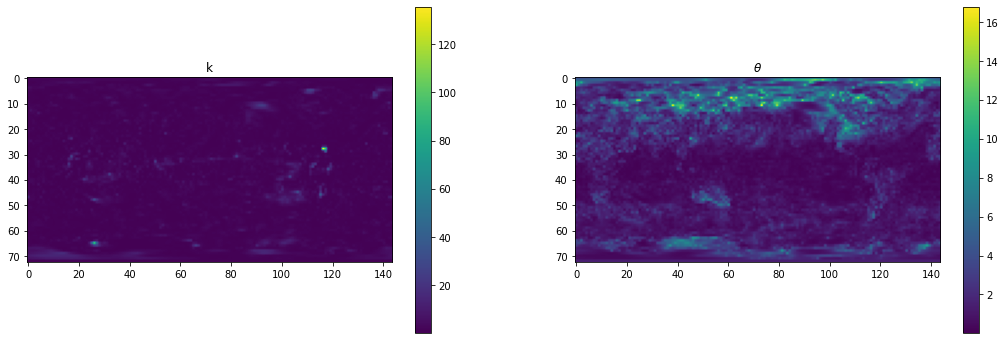

In [30]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('k')
plt.imshow(k[:,:,0].T)
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\theta$')
plt.imshow(theta[:,:,0].T)
plt.colorbar()
plt.show()

In [36]:
def gamma_pdf(x, k, theta):
    g = ( x**(k-1) * np.exp( -x / theta ) ) / ( theta**k * special.gamma(k) )
    return g

In [39]:
@widgets.interact(x=(0, sample_mean.shape[0]-1, 1), y=(0, sample_mean.shape[1]-1, 1))
def show_gamma(x=0, y=0):
    plt.figure(figsize=(18,10))
    plt.subplot(2,1,1)
    plt.imshow(sample_mean[:,:,0].T)
    plt.scatter(x, y, c='magenta', s=2)
    plt.colorbar()

    u = np.linspace(1e-9,120)
    plt.subplot(2,1,2)
    plt.plot(u, gamma_pdf(u, k[y, x, 0], theta[y, x, 0]) )
    plt.grid()

    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=143), IntSlider(value=0, description='y', max=72…

In [41]:
affine = np.eye(4)
affine[2,2] = 10
k_image = nib.Nifti1Image(k, affine)
nib.save(k_image, '../../Data/DEMETER/comparison/ensemble absolute distance/k.nii')
np.save('../../Data/DEMETER/comparison/ensemble absolute distance/k.npy', k)

theta_image = nib.Nifti1Image(theta, affine)
nib.save(theta_image, '../../Data/DEMETER/comparison/ensemble absolute distance/theta.nii')
np.save('../../Data/DEMETER/comparison/ensemble absolute distance/theta.npy', theta)